## Use Psycopg2 to connect to AWS Postgres Database

In [427]:
import psycopg2
import pandas as pd
import pandas.io.sql as pdsql
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation as cv
from sklearn.cross_validation import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, RandomizedLasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

### Connect to Database and Get a Cursor

In [428]:
# dczillow.cfdlhqngxmri.us-east-1.rds.amazonaws.com:5432

con=psycopg2.connect(dbname= 'DCZillow', 
                     host='dczillow.cfdlhqngxmri.us-east-1.rds.amazonaws.com',
                     port='5432',
                     user= 'DCZillow', 
                     password= 'DCZillow');

cur = con.cursor()

### Pull Table into a DataFrame
We stored all weekly data in our Postgres database. Pulling it down into a DataFrame for easier processing.

In [429]:
df = pdsql.read_sql("""SELECT * FROM zillow_weekly""", con)
df.shape

(4690, 82)

In [430]:
cur.close()
con.close()

### Select Only the Variables Needed for Analysis / Modeling

In [431]:
df1 = df[['bedrooms', 'bathrooms', 'yearbuilt', 'lotsizesqft', 'taxassessment_6','finishedsqft',
         'for_sale','zpid','street','city','state','zipcode',
          'zestimate_1', 'zestimate_6', 'percentile_1', 'percentile_6', 'lastsolddate_6', 'lastsoldprice_6',  
         'bedrooms_missing', 'bathrooms_missing', 'yearbuilt_missing', 'lotsizesqft_missing', 'finishedsqft_missing']]

df1.loc[:,'zchange_6wk'] = (df1['zestimate_6'] - df1['zestimate_1']) / df1['zestimate_1']

### Treat Variables and Create Target
Some variables were pulled into the database as the incorrect type. Correcting format here.

In [432]:
df1.loc[:,'lastsolddate_6'] = pd.to_datetime(df1['lastsolddate_6'])
df1.loc[:,'bathrooms'] = pd.to_numeric(df1['bathrooms'], errors='coerse')
df1.loc[:,'lotsizesqft'] = df1['lotsizesqft'].astype(int)
df1.loc[:,'target_2017'] = df1['lastsoldprice_6'] - df1['zestimate_6']

df2 = df1.dropna(subset=['zpid'])
df2.shape


(3990, 25)

### Limit to Only homes sold in 2017
Target window is  set to measure the residual of Sale Price - Zestimate for homes sold in 2017. The Zestimate is as of mid-August. As the target window becomes closer to the snapshot date of mid-August, the number of observations for modeling is reduced.

In [435]:
df2.index = df2['lastsolddate_6']
df3=df2['1/1/2017':]
df3.head(10)

,bedrooms,bathrooms,yearbuilt,lotsizesqft,taxassessment_6,finishedsqft,for_sale,zpid,street,city,...,percentile_6,lastsolddate_6,lastsoldprice_6,bedrooms_missing,bathrooms_missing,yearbuilt_missing,lotsizesqft_missing,finishedsqft_missing,zchange_6wk,target_2017
lastsolddate_6,,,,,,,,,,,,,,,,,,,,,
2017-01-18,4,7.0,2010,17777,10600000.0,10897,1,1.084285e+08,2815 Woodland Dr NW,Washington,...,99.0,2017-01-18,10750000.0,0,0,0,0,0,0.101943,-1766512.0
2017-06-30,2,2.0,1908,565,367380.0,946,1,2.101223e+09,1 Logan Cir NW,Washington,...,0.0,2017-06-30,420000.0,0,0,0,0,0,-0.096241,-350228.0
2017-05-12,2,2.0,1938,1552,162050.0,832,0,5.092020e+05,3427 Eads St NE,Washington,...,73.0,2017-05-12,268000.0,0,0,0,0,0,0.206184,1057.0
2017-07-10,4,4.0,2017,756,523750.0,1700,1,2.093799e+09,2803 Sherman Ave NW # 2,Washington,...,0.0,2017-07-10,669000.0,0,0,0,0,0,-0.107268,-146533.0
2017-04-05,3,1.5,1946,1999,186130.0,1998,0,5.158770e+05,4707 Bass Pl SE,Washington,...,85.0,2017-04-05,160000.0,0,0,0,0,0,0.412250,-170811.0
2017-05-01,2,1.0,1942,1564,435760.0,1175,0,4.473660e+05,3880 Porter St NW APT E353,Washington,...,28.0,2017-05-01,485000.0,0,0,0,0,0,-0.011131,-8254.0
2017-01-10,2,1.0,1942,1502,162280.0,960,1,2.093810e+09,3311 Clay Pl NE # KINGMAN,Washington,...,0.0,2017-01-10,351000.0,0,0,0,0,0,-0.504608,75322.0
2017-04-12,3,2.0,1920,5000,219310.0,1456,0,6.807167e+07,5602 Clay Pl NE,Washington,...,74.0,2017-04-12,150000.0,0,0,0,0,0,0.058562,-118608.0
2017-06-05,3,2.0,1905,12000,315050.0,1802,0,5.255490e+05,2331 High St SE,Washington,...,81.0,2017-06-05,500000.0,0,0,0,0,0,-0.093991,119284.0


### Visualize Predictors
Determine which features need further treatment. for_sale flag is excluded because of its simple binary form.

pchange_6wk need to be treated to remove nulls before inclusion

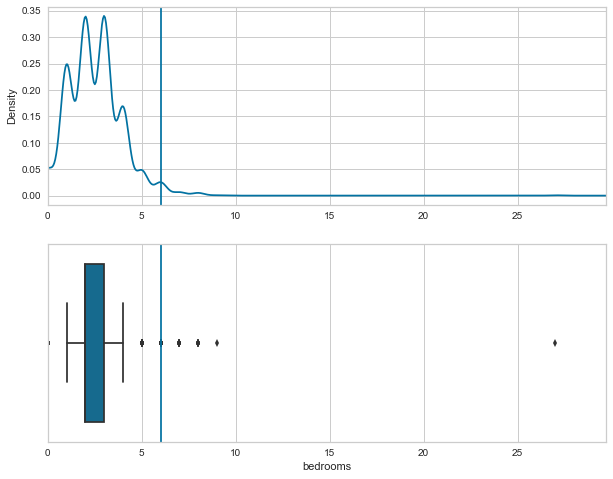

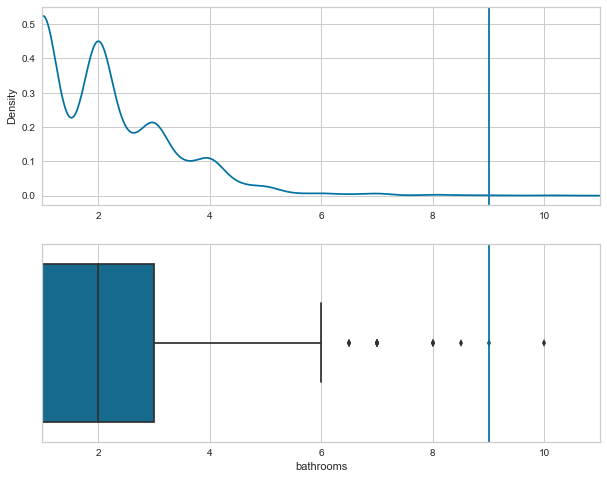

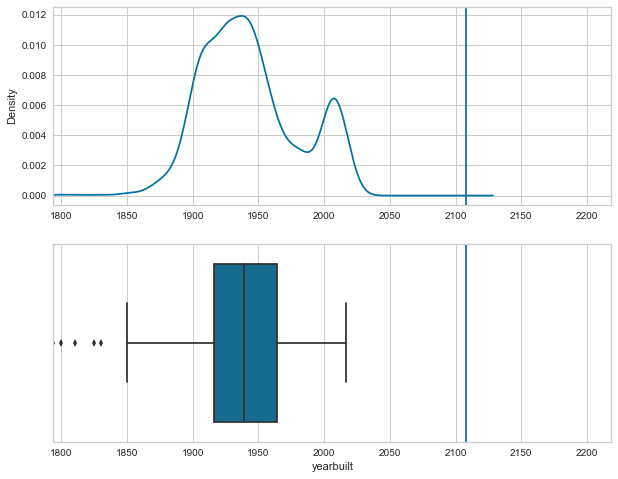

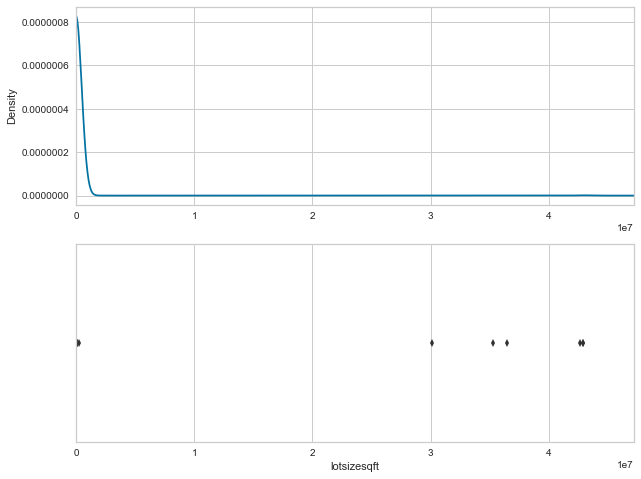

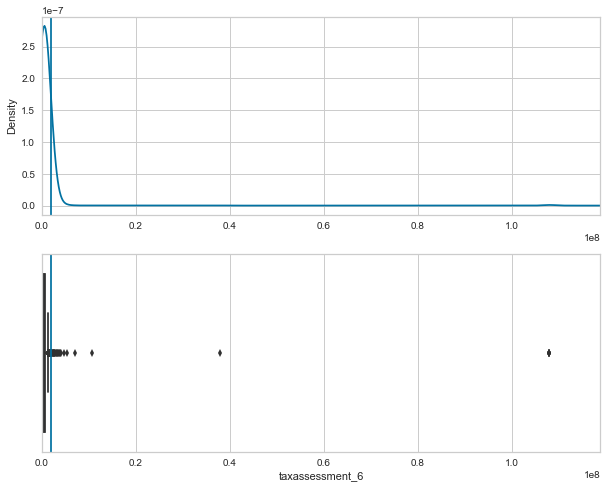

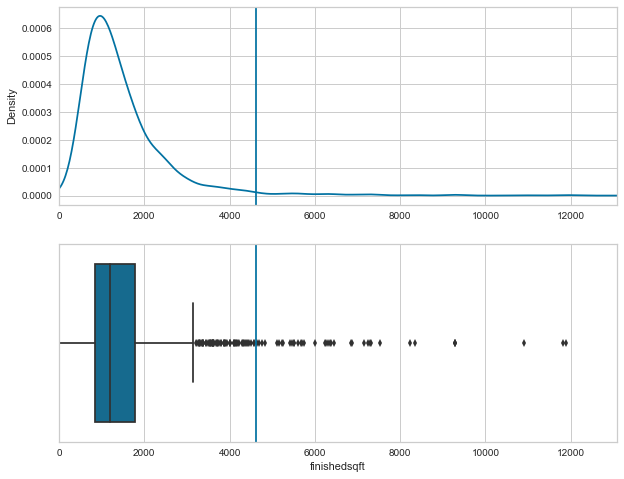

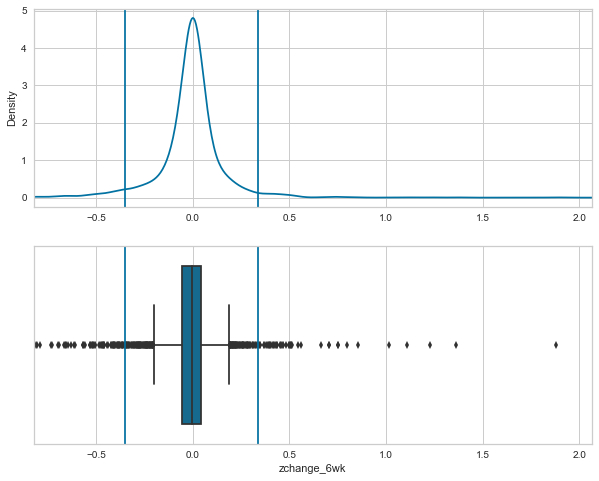

In [436]:
predictors = ['bedrooms', 'bathrooms', 'yearbuilt', 'lotsizesqft', 'taxassessment_6','finishedsqft', 'zchange_6wk']

for i in predictors:

#     plt.figure(figsize=(10,8))
#     plt.subplot(211)
#     plt.xlim(df3[i].min(), df3[i].max()*1.1)

#     ax = df3[i].plot(kind='kde')

#     plt.subplot(212)
#     plt.xlim(df3[i].min(), df3[i].max()*1.1)
#     sns.boxplot(x=df3[i])
#     sns.plt.show()
    
    q25, q75 = np.percentile(df3[i].dropna(), [25 ,75])
    iqr = q75 - q25

    min = q25 - (iqr*3)
    max = q75 + (iqr*3)
    
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.xlim(df3[i].min(), df3[i].max()*1.1)
    plt.axvline(x=min)
    plt.axvline(x=max)

    ax = df3[i].plot(kind='kde')

    plt.subplot(212)
    plt.xlim(df3[i].min(), df3[i].max()*1.1)
    sns.boxplot(x=df3[i])
    plt.axvline(x=min)
    plt.axvline(x=max)
    
    sns.plt.show()


## Takeaways From Basic Visual Data Analysis
#### 1. Functional form of some variables may need to be changed
lotsizesqft and taxassessment may benefit from transforming 

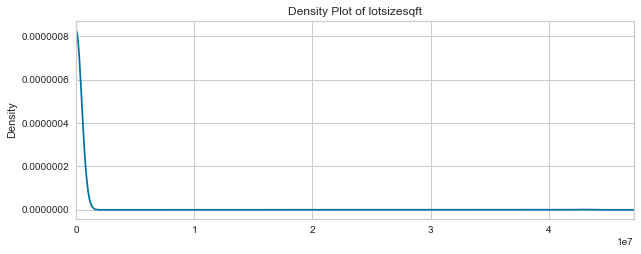

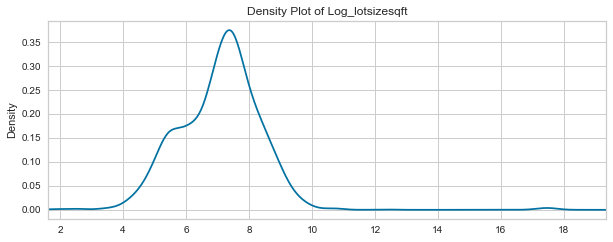

In [437]:
i = 'lotsizesqft'
i2 = 'Log_lotsizesqft'
df3.loc[:,'Log_'+i] = np.log(df3[i])
      
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i].min(), df3[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i].plot(kind='kde')
plt.title('Density Plot of lotsizesqft')

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i2].min(), df3[i2].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i2].plot(kind='kde')
plt.title('Density Plot of Log_lotsizesqft')

sns.plt.show()

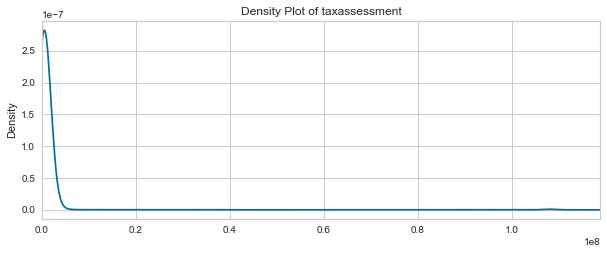

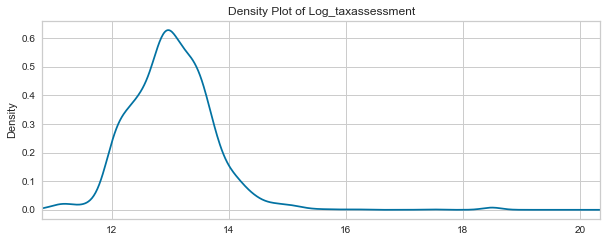

In [438]:
# taxassessment_6 may need to be transformed
i = 'taxassessment_6'
i2 = 'Log_taxassessment_6'
df3.loc[:,'Log_'+i] = np.log(df3[i])
      
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i].min(), df3[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i].plot(kind='kde')
plt.title('Density Plot of taxassessment')

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df3[i2].min(), df3[i2].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
ax = df3[i2].plot(kind='kde')
plt.title('Density Plot of Log_taxassessment')

sns.plt.show()

#### 2. Most fields have extreme values that need to be treated
Cap at 99th percentile

In [439]:
qmax = df3['bedrooms'].quantile(0.99) 
df3[df3['bedrooms'] < qmax] 

qmax = df3['bathrooms'].quantile(0.99) 
df3[df3['bathrooms'] < qmax] 

qmax = df3['Log_lotsizesqft'].quantile(0.99) 
df3[df3['Log_lotsizesqft'] < qmax] 

qmax = df3['Log_taxassessment_6'].quantile(0.99) 
df3[df3['Log_taxassessment_6'] < qmax] 

qmax = df3['finishedsqft'].quantile(0.99) 
df3[df3['finishedsqft'] < qmax] 

qmax = df3['zchange_6wk'].quantile(0.99) 
df3[df3['zchange_6wk'] < qmax] 
    

,bedrooms,bathrooms,yearbuilt,lotsizesqft,taxassessment_6,finishedsqft,for_sale,zpid,street,city,...,lastsoldprice_6,bedrooms_missing,bathrooms_missing,yearbuilt_missing,lotsizesqft_missing,finishedsqft_missing,zchange_6wk,target_2017,Log_lotsizesqft,Log_taxassessment_6
lastsolddate_6,,,,,,,,,,,,,,,,,,,,,
2017-01-18,4,7.00,2010,17777,10600000.0,10897,1,1.084285e+08,2815 Woodland Dr NW,Washington,...,10750000.0,0,0,0,0,0,0.101943,-1766512.0,9.785661,16.176365
2017-06-30,2,2.00,1908,565,367380.0,946,1,2.101223e+09,1 Logan Cir NW,Washington,...,420000.0,0,0,0,0,0,-0.096241,-350228.0,6.336826,12.814152
2017-05-12,2,2.00,1938,1552,162050.0,832,0,5.092020e+05,3427 Eads St NE,Washington,...,268000.0,0,0,0,0,0,0.206184,1057.0,7.347300,11.995660
2017-07-10,4,4.00,2017,756,523750.0,1700,1,2.093799e+09,2803 Sherman Ave NW # 2,Washington,...,669000.0,0,0,0,0,0,-0.107268,-146533.0,6.628041,13.168770
2017-04-05,3,1.50,1946,1999,186130.0,1998,0,5.158770e+05,4707 Bass Pl SE,Washington,...,160000.0,0,0,0,0,0,0.412250,-170811.0,7.600402,12.134201
2017-05-01,2,1.00,1942,1564,435760.0,1175,0,4.473660e+05,3880 Porter St NW APT E353,Washington,...,485000.0,0,0,0,0,0,-0.011131,-8254.0,7.355002,12.984847
2017-01-10,2,1.00,1942,1502,162280.0,960,1,2.093810e+09,3311 Clay Pl NE # KINGMAN,Washington,...,351000.0,0,0,0,0,0,-0.504608,75322.0,7.314553,11.997079
2017-04-12,3,2.00,1920,5000,219310.0,1456,0,6.807167e+07,5602 Clay Pl NE,Washington,...,150000.0,0,0,0,0,0,0.058562,-118608.0,8.517193,12.298242
2017-06-05,3,2.00,1905,12000,315050.0,1802,0,5.255490e+05,2331 High St SE,Washington,...,500000.0,0,0,0,0,0,-0.093991,119284.0,9.392662,12.660487


#### 2. Variables with Multimodal distributions need to be assessed more closely
Yearbuilt illustrates two peaks of building in DC are between 1900 and 1950 and shortly after 2000. May be a case to derive variable or interaction to better differentiate the effect.

/Users/gbq483/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


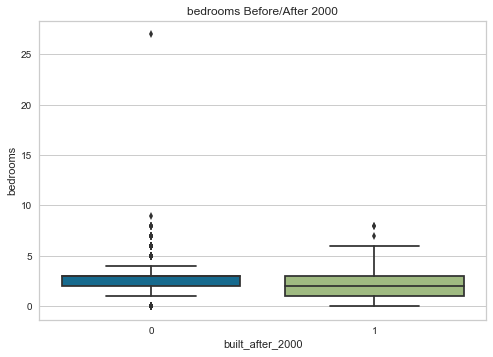

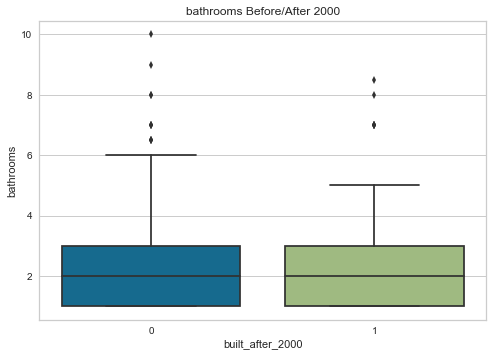

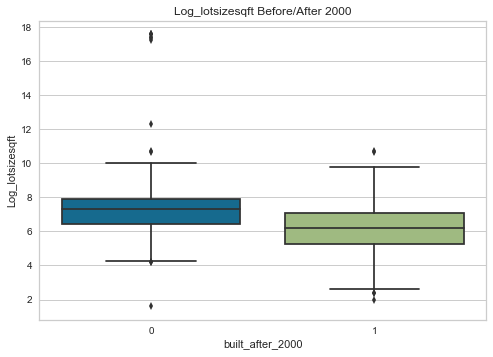

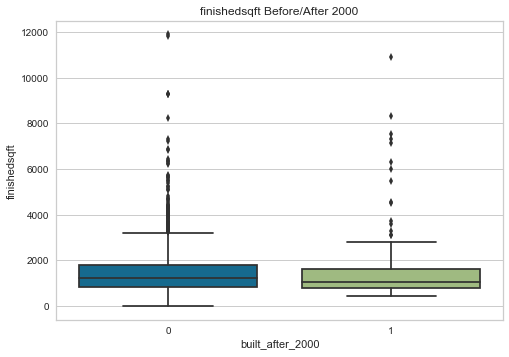

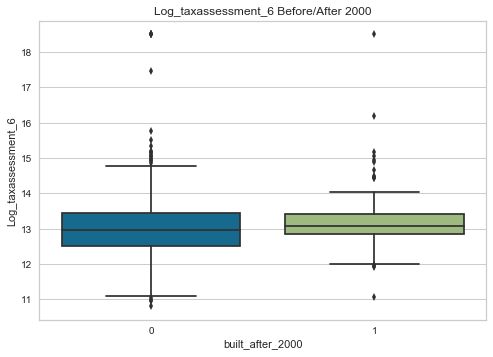

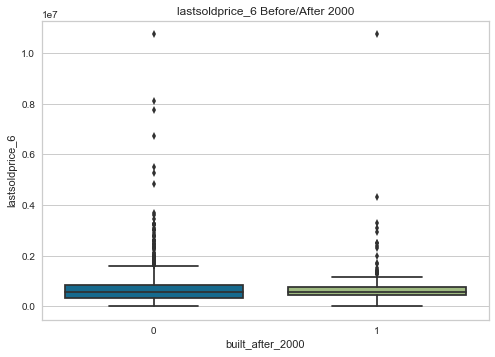

In [440]:
df3['built_after_2000'] = df3['yearbuilt'] > 2000
df3.loc[:,'built_after_2000'] = df3['built_after_2000'].astype(int)

g = sns.boxplot(y='bedrooms', x='built_after_2000', data=df3)
t = g.set_title("bedrooms Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='bathrooms', x='built_after_2000', data=df3)
t = g.set_title("bathrooms Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='Log_lotsizesqft', x='built_after_2000', data=df3)
t = g.set_title("Log_lotsizesqft Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='finishedsqft', x='built_after_2000', data=df3)
t = g.set_title("finishedsqft Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='Log_taxassessment_6', x='built_after_2000', data=df3)
t = g.set_title("Log_taxassessment_6 Before/After 2000")
sns.plt.show()

g = sns.boxplot(y='lastsoldprice_6', x='built_after_2000', data=df3)
t = g.set_title("lastsoldprice_6 Before/After 2000")
sns.plt.show()


In [441]:
# Impute null pchange to median
medbedrooms = np.median(df3.bedrooms)   
df3.bedrooms = df3.bedrooms.fillna(medbedrooms)

medbathrooms = np.median(df3.bathrooms)   
df3.bathrooms = df3.bathrooms.fillna(medbathrooms)

medLog_lotsizesqft = np.median(df3.Log_lotsizesqft)   
df3.Log_lotsizesqft = df3.Log_lotsizesqft.fillna(medLog_lotsizesqft)

medLog_taxassessment_6 = np.median(df3.Log_taxassessment_6)   
df3.Log_taxassessment_6 = df3.Log_taxassessment_6.fillna(medLog_taxassessment_6)

medfinishedsqft = np.median(df3.finishedsqft)   
df3.finishedsqft = df3.finishedsqft.fillna(medfinishedsqft)

medzchange_6wk = np.median(df3.zchange_6wk)   
df3.zchange_6wk = df3.zchange_6wk.fillna(medzchange_6wk)

medfor_sale = np.median(df3.for_sale)   
df3.for_sale = df3.for_sale.fillna(medfor_sale)

medyearbuilt = np.median(df3.yearbuilt)   
df3.yearbuilt = df3.yearbuilt.fillna(medyearbuilt)

medbuilt_after_2000 = np.median(df3.built_after_2000)   
df3.built_after_2000 = df3.built_after_2000.fillna(medbuilt_after_2000)


In [442]:
# Create indicators for property size
df3.loc[:,'sqft_lt1000'] = df3['finishedsqft'] < 1000
df3.loc[:,'sqft_lt1000'] = df3['sqft_lt1000'].astype(int)

df3.loc[:,'sqft_lt1500'] = df3['finishedsqft'] < 1500
df3.loc[:,'sqft_lt1500'] = df3['sqft_lt1500'].astype(int)

df3.loc[:,'sqft_lt2000'] = df3['finishedsqft'] < 2000
df3.loc[:,'sqft_lt2000'] = df3['sqft_lt2000'].astype(int)

df3.loc[:,'sqft_lt2500'] = df3['finishedsqft'] < 2500
df3.loc[:,'sqft_lt2500'] = df3['sqft_lt2500'].astype(int)

df3.loc[:,'sqft_ge2500'] = df3['finishedsqft'] >= 2500
df3.loc[:,'sqft_ge2500'] = df3['sqft_ge2500'].astype(int)

### Plot predictors against the target

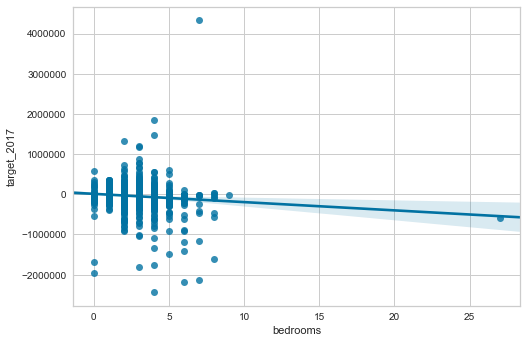

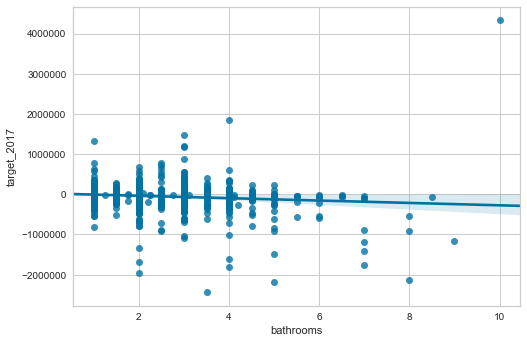

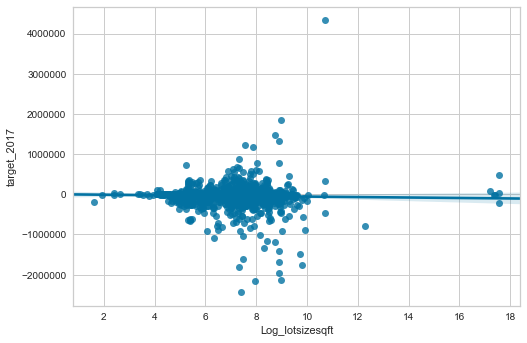

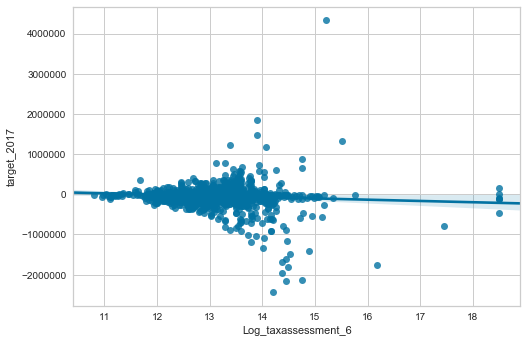

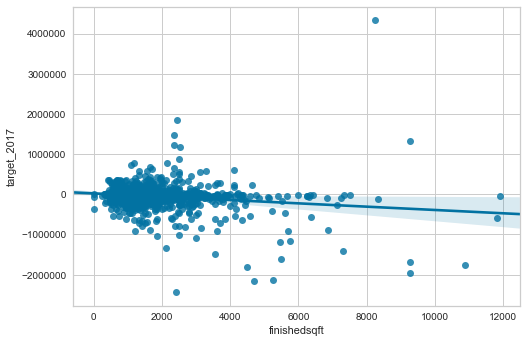

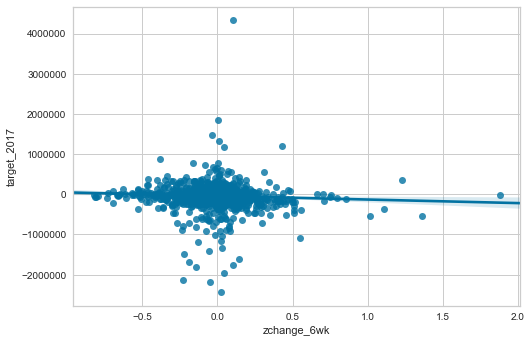

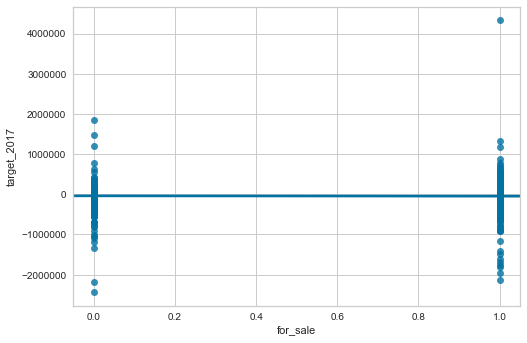

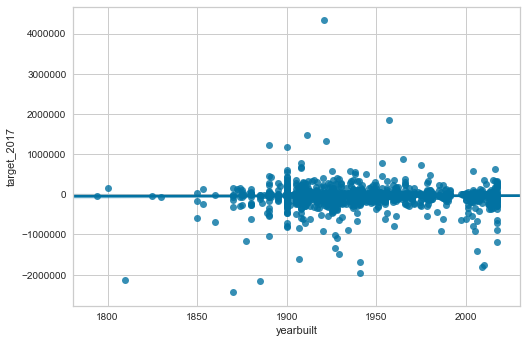

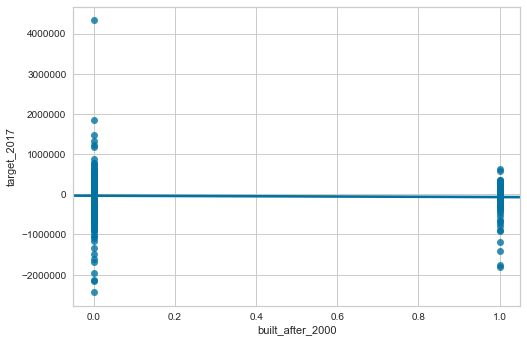

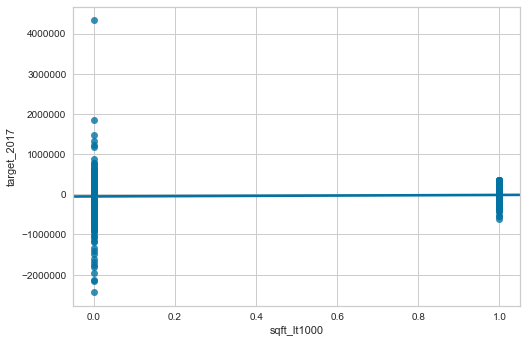

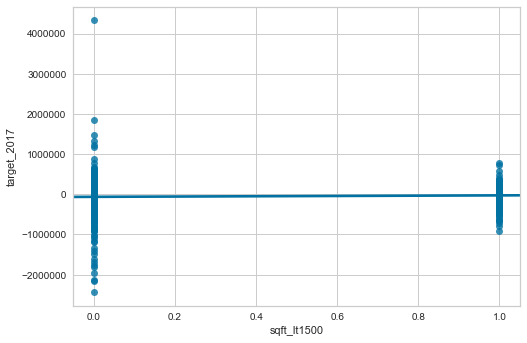

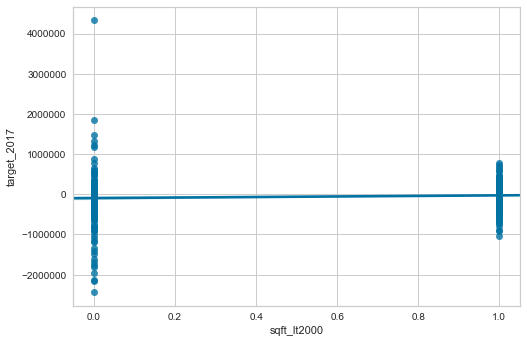

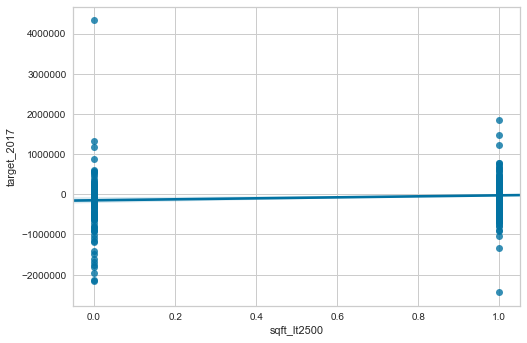

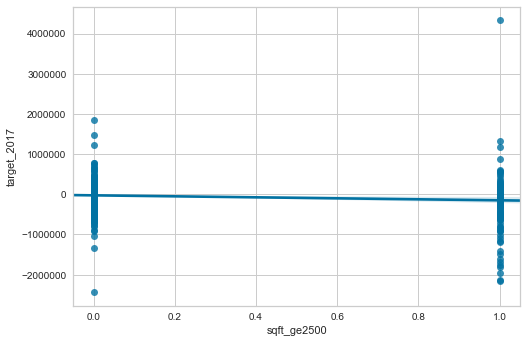

In [443]:
g = sns.regplot(x="bedrooms", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="bathrooms", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="Log_lotsizesqft", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="Log_taxassessment_6", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="finishedsqft", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="zchange_6wk", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="for_sale", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="yearbuilt", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="built_after_2000", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt1000", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt1500", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt2000", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_lt2500", y="target_2017", data=df3)
sns.plt.show()

g = sns.regplot(x="sqft_ge2500", y="target_2017", data=df3)
sns.plt.show()


### Correlation of Predictors
#### Bedrooms and Bathrooms are correlated; Sqft, bedrooms, and bathrooms are correlated; all missing inds are correlated

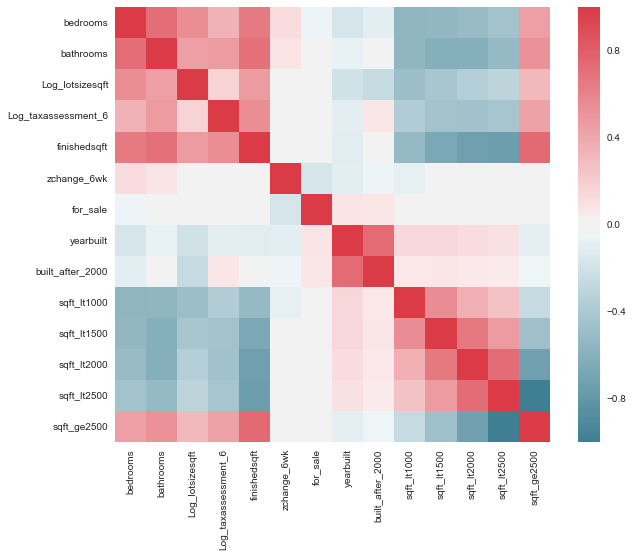

In [444]:
features = df3[['bedrooms', 'bathrooms', 'Log_lotsizesqft', 'Log_taxassessment_6','finishedsqft', 'zchange_6wk', 
             'for_sale', 'yearbuilt', 'built_after_2000', 'sqft_lt1000', 'sqft_lt1500', 'sqft_lt2000', 'sqft_lt2500', 'sqft_ge2500']]

target = df3[['target_2017']]

f, ax = plt.subplots(figsize=(10, 8))
corr = features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.plt.show()

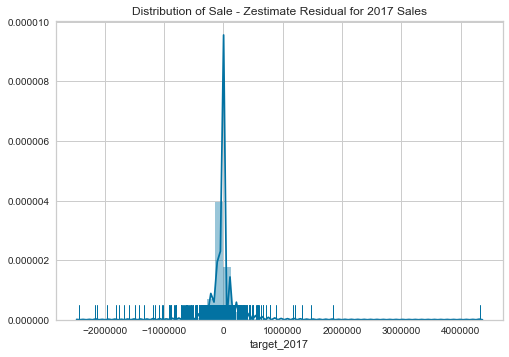

In [445]:
g = sns.distplot(target.target_2017, rug=True, kde=True)
t = g.set_title("Distribution of Sale - Zestimate Residual for 2017 Sales")
sns.plt.show()

### Assess if features are predictive

In [446]:
features.describe()

,bedrooms,bathrooms,Log_lotsizesqft,Log_taxassessment_6,finishedsqft,zchange_6wk,for_sale,yearbuilt,built_after_2000,sqft_lt1000,sqft_lt1500,sqft_lt2000,sqft_lt2500,sqft_ge2500
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000
mean,2.531859,2.135887,7.073560,13.023037,1500.259610,-0.008701,0.286467,1943.530806,0.148499,0.355977,0.644550,0.806740,0.888889,0.111111
std,1.489129,1.180729,1.348048,0.734481,1107.526906,0.174195,0.452229,37.126453,0.355688,0.478934,0.478776,0.394959,0.314352,0.314352
min,0.000000,1.000000,1.609438,10.809324,1.000000,-0.822254,0.000000,1794.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,6.215607,12.549057,832.500000,-0.054759,0.000000,1916.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,2.000000,2.000000,7.190676,12.991206,1200.000000,-0.002077,0.000000,1939.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,3.000000,7.832808,13.431009,1778.000000,0.043278,1.000000,1964.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,27.000000,10.000000,17.574536,18.497642,11898.000000,1.876423,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [447]:
target.describe()

,target_2017
count,1.899000e+03
mean,-4.081325e+04
std,2.496943e+05
min,-2.436610e+06
25%,-6.904100e+04
50%,-1.042200e+04
75%,4.172000e+03
max,4.327673e+06


In [448]:
model = RandomizedLasso(alpha=0.05)
model.fit(features, target["target_2017"])
names = list(features)

print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), model.scores_), 
                 names), reverse=True))

Features sorted by their score:
[(1.0, 'zchange_6wk'), (1.0, 'finishedsqft'), (0.995, 'yearbuilt'), (0.995, 'sqft_lt2000'), (0.995, 'sqft_lt1500'), (0.995, 'built_after_2000'), (0.995, 'bathrooms'), (0.995, 'Log_lotsizesqft'), (0.99, 'for_sale'), (0.985, 'bedrooms'), (0.98, 'sqft_lt1000'), (0.98, 'Log_taxassessment_6'), (0.625, 'sqft_lt2500'), (0.37, 'sqft_ge2500')]


### Create Train / Test Split and Assess Basic Models

In [449]:
splits = cv.train_test_split(features, target, test_size=0.2)
X_train, X_test, y_train, y_test = splits

In [453]:
model = Ridge(alpha=0.05)
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Ridge Regression model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

print('ridge.coef_: {}'.format(model.coef_))
print('ridge.intercept_: {}'.format(model.intercept_))

Ridge Regression model
Root Mean Squared Error: 239981.447
Coefficient of Determination: -0.026
ridge.coef_: [[ -4.40659781e+03  -4.05837687e+03   1.34031311e+04   9.40248402e+03
   -7.22648878e+01  -8.62074535e+04  -1.74939722e+03   4.91819215e+02
   -6.80962822e+04  -9.61470006e+03  -5.47893781e+04  -1.60952889e+04
    9.87784773e+03  -9.87784773e+03]]
ridge.intercept_: [-1033289.08483613]


In [454]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Linear Regression model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("Coefficient of Determination: %0.3f" % r2_score(expected, predicted))

Linear Regression model
Root Mean Squared Error: 239982.076
Coefficient of Determination: -0.026


In [455]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print("Random Forest model")
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(expected, predicted))))
print("R2 score = %0.3f" % r2_score(expected, predicted))

Random Forest model
Root Mean Squared Error: 275615.127
R2 score = -0.354


/Users/gbq483/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [425]:
import yellowbrick as yb
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof() 

/Users/gbq483/anaconda/lib/python2.7/site-packages/yellowbrick/base.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


ValueError: Shape of passed values is (1519, 1519), indices imply (1, 1519)